### 1.0 - Visualizando as 4 estações virtuais mais próximas da estação de Traipu

In [2]:
#Inserindo caminho da pasta onde estão os modulos que utilizaremos
import sys
import geopandas as gpd
sys.path.insert(0, r"C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\modulos")

#Importando os módulos
import modulo3_stations_virtual as modulo3
import modulo1_station_processing as modulo1 
import modulo2_statistics as modulo2

#Importanddo função para unir diversas geometrias 
from shapely.ops import cascaded_union, unary_union

#Leitura rquivo região de interesse (semiarido)
semiarido = gpd.read_file(r"C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\semiarido_2021\semiarido_2021.shp", crs='EPSG:4326')

#Vamos excluir os municípios que não fazem parte do Semiárido e unir a geometria ds demais, para termos uma única
semiarido_union = unary_union(semiarido[semiarido.Situacao != 'Excluído - Em contestação'].geometry)
semiarido_union = gpd.GeoDataFrame(geometry = [semiarido_union], crs='EPSG:4326')

#Caminho da pasta na qual o arquivo de interesse está localizado
#path = r"C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\dados\DAILY_RAIN\MERGE_CPTEC_20100604.grib2"

path = r'C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\dados\MONTHLY_ACCUM_MANUAL\MERGE_CPTEC_acum_jul_2020.nc'
#Realizando leitura do arquivo
df_prec = modulo3.read_file_precipitation_grib(path, temporal_scaling="monthly_accum_manual") 

#Buscando por um ponto (com dados de satélite) mais próximo possível da estação de interesse
# Coordenadas estação de Traipu
coords =  modulo3.Point((-37.0033, -9.9728))
station_real = gpd.GeoDataFrame(geometry=[coords]) 
stations_virtual = modulo3.find_station_virtual(df_prec, station_real.geometry[0])

#Visualizando
#modulo3.map_stations(semiarido_union, station_real, stations_virtual, df_prec, 'Semiárido', 'Traipú') 

### 2.0 - Interpolação bilinear

In [3]:
import numpy as np
#Lendo arquivo de uma estação qualquer, neste caso, de Traipú
path = r'C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\Dados_estações\TRAIPU (1).xlsx'
df_traipu = modulo1.read_station(path)

#Selecionando lista com estações e ponto de interesse (estação Traipu)
list_stations = modulo3.organizing_stations(stations_virtual)
point_coords = (-37.00330, -9.97280)

#Calculando interpolação bilinear para as coordenadas da estação de Traipu
prec_interpolation = modulo3.bilinear_interpolation(point_coords, list_stations)

#Verificando valor de precipitação na estação de Traipu
prec_traipu = df_traipu[df_traipu.Data == "2020-02-04"]['Precipitação (mm)'].to_list()[0]

#Visualizando
print('Precipitação (interpolada): ', np.around(prec_interpolation, 3), " mm")
#print('Precipitção (Traipu) ', prec_traipu, " mm") 

Precipitação (interpolada):  60.743  mm


In [105]:
df_traipu

Data  Precipitação (mm)
ID         geometry                                              
ANA_936076 POINT (-9.9728 -37.0033) 1973-01-01                0.0
           POINT (-9.9728 -37.0033) 1973-01-02                0.0
           POINT (-9.9728 -37.0033) 1973-01-03                1.7
           POINT (-9.9728 -37.0033) 1973-01-04                0.5
           POINT (-9.9728 -37.0033) 1973-01-05                0.2
...                                        ...                ...
           POINT (-9.9728 -37.0033) 2023-06-26                1.9
           POINT (-9.9728 -37.0033) 2023-06-27                0.0
           POINT (-9.9728 -37.0033) 2023-06-28                8.6
           POINT (-9.9728 -37.0033) 2023-06-29                1.2
           POINT (-9.9728 -37.0033) 2023-06-30                0.4

[17517 rows x 2 columns]

In [4]:
#importando funções
import os
import glob
from shapely import Point

#============================================================================================================
#                               FUNÇÕES PARA EXTRAIR NOMES DOS ARQUIVOS (SATÉLITE) 
#============================================================================================================


def filter_annual_path(path, year=2019, name_extension_file='grib2'):
    ''' Seleciona o nome das pastas com dados diários para um ano especificado '''

    list_path = glob.glob(os.path.join(path, "*." + str(name_extension_file))) 
    list_path = [path for path in list_path if str(year) in path]

    return list_path

def filter_range_annual_path(path, year_start=2019, year_end=2020, name_extension_file='grib2'):
    ''' Seleciona o nome das pastas com dados para um intervalo de anos especificado '''
    
    list_path = [path_name for year in range(year_start, year_end + 1) 
                 for path_name in filter_annual_path(path, year, name_extension_file)]
    
    return list_path

def filter_month_path(path, month=202001, name_extension_file='grib2'):
    ''' Seleciona um mês de um ano específico '''

    list_path = glob.glob(os.path.join(path, "*." + str(name_extension_file))) 
    list_path = [path for path in list_path if str(month) in path]

    return list_path

#============================================================================================================
#                             FUNÇÕES PARA EXTRAIR SÉRIES TEMPORAIS DE UM ÚNICO PIXEL
#============================================================================================================

def prec_series_grib(x_point, y_point, list_path, temporal_scaling='dailly_rain'):

    ''' Gera uma série de dados para um ponto específico do arquivo grib
    x_point: coodenada x do ponto de interesse dos dados de setélite
    y_point: coordenada y do ponto de interesse
    list_path: lista com a pasta de cada arquivo que desejamos realizar a leitura '''

    #Criando dataframe para armazenar dados
    df_prec = gpd.GeoDataFrame(columns=['prec', 'Date', 'path'])

    #Apenas criando duas listas, cada uma para armazenar valores de precipitação e a data
    list_prec, list_date = [], []
            
    #Lendo arquivo com dados de cada dia, porém em diversos pontos 
    list_prec_day = [modulo3.read_file_precipitation_grib(path, temporal_scaling=temporal_scaling) for path in list_path]

    #Selecionando o valor de um ponto específico
    list_filter_point = [prec_day[(np.around(prec_day.geometry.x, 2) == x_point) & (np.around(prec_day.geometry.y, 2) == y_point)] for prec_day in list_prec_day]

    #Adicionando a lista os valores de precipitação e a data
    prec = [filter_point.prec.to_list()[0] for filter_point in list_filter_point]
    list_prec.append(prec)

    date = [filter_point.time.to_list()[0] for filter_point in list_filter_point]
    list_date.append(date)

    #Acrescentando ao dataframe
    df_prec['prec'], df_prec['Date'] = list_prec, list_date

    return df_prec 


#============================================================================================================
#                         FUNÇÕES PARA CALCULAR INTERPOLAÇÃO BILINEAR DOS ARQUIVOS (SATÉLITE) 
#                                           (comparação PIXEL Ponto)
#============================================================================================================

def calc_interpolation_series(coords_station, list_name_files, df_station, temp_scale='dailly_rain'):

    #Guardando em uma lista os valores
    values_station = df_station['Precipitação (mm)'].to_list()

    #Armazenando coordenadas da estação
    station_real = gpd.GeoDataFrame(geometry=[Point(coords_station)]) 

    #Lista para guardar resultado dos valores interpolados
    values_interpolation = [] 

    #Realizando leitura do arquivo
    list_df_prec = [modulo3.read_file_precipitation_grib(path_data, temporal_scaling=temp_scale) for path_data in list_name_files]
    
    #Procurando as 4 estaçõs virtuais mais próximas
    list_stations_virtual = [modulo3.find_station_virtual(df_prec, station_real.geometry[0]) for df_prec in list_df_prec]
    
    #Selecionando lista com estações e ponto de interesse (estação Traipu)
    list_stations = [modulo3.organizing_stations(stations_virtual) for stations_virtual in list_stations_virtual]

    #Calculando interpolação bilinear para as coordenadas da estação de Traipu
    prec_interpolation = [modulo3.bilinear_interpolation(coords_station, stations) for stations in list_stations]
    
    return values_station, prec_interpolation 




In [5]:
def prec_series_grib(x_point, y_point, list_path, temporal_scaling='dailly_rain'):

    ''' Gera uma série de dados para um ponto específico do arquivo grib
    x_point: coodenada x do ponto de interesse dos dados de setélite
    y_point: coordenada y do ponto de interesse
    list_path: lista com a pasta de cada arquivo que desejamos realizar a leitura '''

    #Criando dataframe para armazenar dados
    df_prec = gpd.GeoDataFrame(columns=['prec', 'Date', 'path'])

    #Apenas criando duas listas, cada uma para armazenar valores de precipitação e a data
    list_prec, list_date = [], []
            
    #Lendo arquivo com dados de cada dia, porém em diversos pontos 
    list_prec_day = [modulo3.read_file_precipitation_grib(path, temporal_scaling=temporal_scaling) for path in list_path]

    #Selecionando o valor de um ponto específico
    list_filter_point = [prec_day[(np.around(prec_day.geometry.x, 2) == x_point) & (np.around(prec_day.geometry.y, 2) == y_point)] for prec_day in list_prec_day]

    #Adicionando a lista os valores de precipitação e a data
    prec = [filter_point.prec.to_list()[0] for filter_point in list_filter_point]
    list_prec.append(prec)

    date = [filter_point.time.to_list()[0] for filter_point in list_filter_point]
    list_date.append(date)

    #Acrescentando ao dataframe
    df_prec['prec'], df_prec['Date'] = list_prec, list_date

    return df_prec 
#============================================================================================================


def read_grib(list_path, temporal_scaling):
    #Criando dataframe para armazenar dados
    df_prec = gpd.GeoDataFrame(columns=['prec', 'Date', 'path'])

    #Apenas criando duas listas, cada uma para armazenar valores de precipitação e a data
    list_prec, list_date = [], []
            
    #Lendo arquivo com dados de cada dia, porém em diversos pontos 
    list_prec_day = [modulo3.read_file_precipitation_grib(path, temporal_scaling=temporal_scaling) for path in list_path]

    return list_prec_day

def filter_data(x_point, y_point, list_data):
    #Selecionando o valor de um ponto específico
    list_filter_point = [prec_day[(np.around(prec_day.geometry.x, 2) == x_point) & (np.around(prec_day.geometry.y, 2) == y_point)] for prec_day in list_prec_day]

    return list_filter_point

def save_data(list_filter_point):
    #Criando dataframe para armazenar dados
    df_prec = gpd.GeoDataFrame(columns=['prec', 'Date', 'path'])

    #Apenas criando duas listas, cada uma para armazenar valores de precipitação e a data
    list_prec, list_date = [], []

    #Adicionando a lista os valores de precipitação e a data
    prec = [filter_point.prec.to_list()[0] for filter_point in list_filter_point]
    list_prec.append(prec)

    date = [filter_point.time.to_list()[0] for filter_point in list_filter_point]
    list_date.append(date)

    #Acrescentando ao dataframe
    df_prec['prec'], df_prec['Date'] = list_prec, list_date

    return df_prec 




## Acumulados mesais

In [5]:
#Filtrando os dados da estação para uma data específica
range_data = df_traipu[(df_traipu.Data >= "2001-01-01") & (df_traipu.Data <= "2002-12-31")]

#Calculando acumulados mensais para um único ano
traipu_month_accum = modulo2.month_statistics(range_data, opc=0)
traipu_month_accum = traipu_month_accum[traipu_month_accum.index != '2009-06-30']

traipu_month_accum

,Precipitação (mm)
Data,
2001-01-31,9.8
2001-02-28,0.4
2001-03-31,25.4
2001-04-30,25.2
2001-05-31,16.6
...,...
2018-08-31,5.5
2018-09-30,8.9
2018-10-31,0.0


## Testandoo nova função

In [140]:
path = r'C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\dados\MONTHLY_ACCUM_MANUAL'

files_old = filter_range_annual_path(path, year_start=2001, year_end=2002, name_extension_file='nc') 

traipu_month_accum_old = traipu_month_accum.copy()

traipu_month_accum_old = traipu_month_accum_old[(traipu_month_accum_old.index.year >= 2001) & (traipu_month_accum_old.index.year <= 2002)]

coords_station = (-37.00330, -9.97280)

interpolation_old = calc_interpolation_series(coords_station, files_old, traipu_month_accum_old, temp_scale='monthly_accum_manual')

In [139]:
path = r'C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\dados\MONTHLY_ACCUM_MANUAL'

files_new = filter_range_annual_path(path, year_start=2001, year_end=2002, name_extension_file='nc') 

traipu_month_accum_new = traipu_month_accum.copy()

traipu_month_accum_new = traipu_month_accum_new[(traipu_month_accum_new.index.year >= 2001) & (traipu_month_accum_new.index.year <= 2002)]

coords_station = (-37.00330, -9.97280)

interpolation_old = calc_interpolation_series_new(coords_station, files_new, traipu_month_accum_new, temp_scale='monthly_accum_manual')

In [108]:
path = r'C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\dados\MONTHLY_ACCUM_MANUAL'

files = filter_range_annual_path(path, year_start=2001, year_end=2018, name_extension_file='nc')

coords_station = (-37.00330, -9.97280)

interpolation = calc_interpolation_series(coords_station, files, traipu_month_accum, temp_scale='monthly_accum_manual')

In [8]:
import multiprocessing
import time

In [29]:
#Filtrando os dados da estação para uma data específica
range_data = df_traipu[(df_traipu.Data >= "2001-01-01") & (df_traipu.Data <= "2002-12-31")]

#Calculando acumulados mensais para um único ano
traipu_month_accum = modulo2.month_statistics(range_data, opc=0)
traipu_month_accum = traipu_month_accum[traipu_month_accum.index != '2009-06-30']

In [32]:
def test_paralelism():
    path = r'C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\dados\MONTHLY_ACCUM_MANUAL'

    files = filter_range_annual_path(path, year_start=2001, year_end=2002, name_extension_file='nc')

    coords_station = (-37.00330, -9.97280)

    interpolation = calc_interpolation_series(coords_station, files, traipu_month_accum, temp_scale='monthly_accum_manual')

    print(interpolation[1])
    print('a')

In [38]:
def test(num):
    print('deu certo ', 2*num)

inicio = time.perf_counter()

if __name__ == '__main__':

    cod = multiprocessing.Process(target=test, args=(10, ))
    cod.start()
    cod.join()

    fim = time.perf_counter()



In [39]:


# importing the multiprocessing module 
import multiprocessing 
  
def print_cube(num): 
    """ 
    function to print cube of given num 
    """
    print("Cube: {}".format(num * num * num)) 
  
def print_square(num): 
    """ 
    function to print square of given num 
    """
    print("Square: {}".format(num * num)) 
  
if __name__ == "__main__": 
    # creating processes 
    p1 = multiprocessing.Process(target=print_square, args=(10, )) 
    p2 = multiprocessing.Process(target=print_cube, args=(10, )) 
  
    # starting process 1 
    p1.start() 
    # starting process 2 
    p2.start() 
  
    # wait until process 1 is finished 
    p1.join() 
    # wait until process 2 is finished 
    p2.join() 
  
    # both processes finished 
    print("Done!") 

Done!


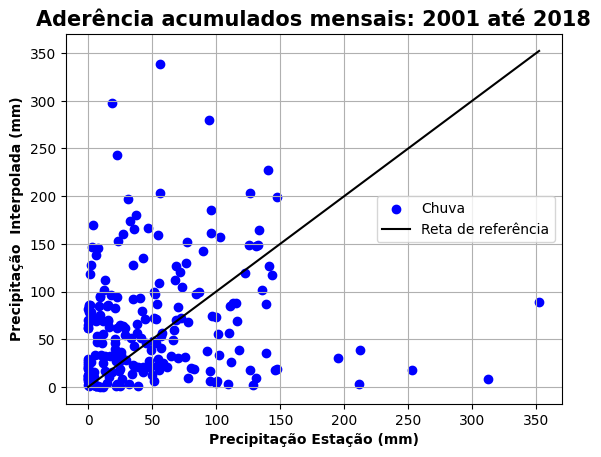

In [117]:
import matplotlib.pyplot as plt

data_station, data_interpolation = interpolation[0], interpolation[1]

prec_month_accum_max = max(traipu_month_accum['Precipitação (mm)'].to_list())

fig, ax = plt.subplots()

ax.scatter(np.array(data_station), np.array(data_interpolation), color='blue')
ax.plot([0, prec_month_accum_max], [0, prec_month_accum_max], color='black')

plt.title('Aderência acumulados mensais: 2001 até 2018', size=15, weight='bold')
plt.xlabel('Precipitação Estação (mm)', size=10, weight='bold')
plt.ylabel('Precipitação  Interpolada (mm)', size=10, weight='bold')
plt.legend(['Chuva', 'Reta de referência'])
plt.grid()

plt.show()

In [114]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [115]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

#Calculando erro médio absoluto e raiz do erro quadrático médio
MAE = mean_absolute_error(data_station, data_interpolation)
RMSE = root_mean_squared_error(data_station, data_interpolation)

#Visualizando
print("MAE = ", MAE)
print('RMSE = ', RMSE)


MAE =  54.23867187053112
RMSE =  77.78911500530809


## Acumulados Anuais

In [33]:
#Filtrando os dados da estação para uma data específica
range_data = df_traipu[(df_traipu.Data >= "2001-01-01") & (df_traipu.Data <= "2022-12-31")]

#Calculando acumulados mensais para um único ano
traipu_annual_accum = modulo2.annual_statistics(range_data, opc=0)

#Pasta com valores mensais baixados (satélite)  
path_data_annual = r'C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\dados\YEARLY_ACCUM'

files_annual_accum = filter_range_annual_path(path_data_annual, year_start=2001, year_end=2022, name_extension_file='nc')

#Coordenadas do ponto de interesse
coords = (-37.0033, -9.9728)

#Realizando interpolação
interpolation_accum_annual = calc_interpolation_series(coords, files_annual_accum, traipu_annual_accum, temp_scale='yearly_accum')


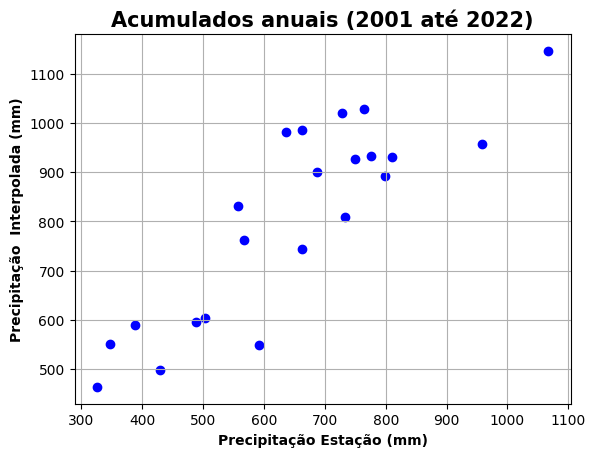

In [37]:
import matplotlib.pyplot as plt

data_station_annual, data_interpolation_annual = interpolation_accum_annual[0], interpolation_accum_annual[1]

plt.scatter(np.array(data_station_annual), np.array(data_interpolation_annual), color='blue')
plt.title('Acumulados anuais (2001 até 2022)', size=15, weight='bold')
plt.xlabel('Precipitação Estação (mm)', size=10, weight='bold')
plt.ylabel('Precipitação  Interpolada (mm)', size=10, weight='bold')
plt.grid()

plt.show()

In [38]:
#Calculando erro médio absoluto e raiz do erro quadrático médio
MAE_annual_accum = mean_absolute_error(data_station_annual, data_interpolation_annual)
RMSE_annual_accum = root_mean_squared_error(data_station_annual, data_interpolation_annual)

#Visualizando
print("MAE acumulado anual = ", MAE_annual_accum)
print('RMSE acumulado anual = ', RMSE_annual_accum)

MAE acumulado anual =  161.90697772726546
RMSE acumulado anual =  186.87048125199053


## Dados diários

In [45]:
from shapely import Point

def prec_series_grib(x_point, y_point, list_path, temporal_scaling='dailly_rain'):

    ''' Gera uma série de dados para um ponto específico do arquivo grib
    x_point: coodenada x do ponto de interesse dos dados de setélite
    y_point: coordenada y do ponto de interesse
    list_path: lista com a pasta de cada arquivo que desejamos realizar a leitura '''

    #Criando dataframe para armazenar dados
    df_prec = gpd.GeoDataFrame(columns=['prec', 'Date'])

    #Apenas criando duas listas, cada uma para armazenar valores de precipitação e a data
    list_prec, list_date = [], []
            
    #Lendo arquivo com dados de cada dia, porém em diversos pontos 
    list_prec_day = [modulo3.read_file_precipitation_grib(path, temporal_scaling=temporal_scaling) for path in list_path]

    #Selecionando o valor de um ponto específico
    list_filter_point = [prec_day[(np.around(prec_day.geometry.x, 2) == x_point) & (np.around(prec_day.geometry.y, 2) == y_point)] for prec_day in list_prec_day]

    #Adicionando a lista os valores de precipitação e a data
    prec = [filter_point.prec.to_list()[0] for filter_point in list_filter_point]
    date = [filter_point.time.to_list()[0] for filter_point in list_filter_point]

    #Acrescentando ao dataframe
    df_prec['prec'], df_prec['Date'] = prec, date

    return df_prec 

In [12]:
#Selecionando arquivos diários de um ano específico
path = r'C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\dados\DAILY_RAIN'
files = filter_range_annual_path(path, year_start=2015, year_end=2015, name_extension_file='grib2')


In [16]:
files[:5]

['C:\\Users\\Ari\\Documents\\UFAL\\Pesquisa\\PIBIC 23-24\\Dados\\LIB INPE\\modulos_tratamento_dados\\modulos_tratamento_dados\\dados\\DAILY_RAIN\\MERGE_CPTEC_20150101.grib2',
 'C:\\Users\\Ari\\Documents\\UFAL\\Pesquisa\\PIBIC 23-24\\Dados\\LIB INPE\\modulos_tratamento_dados\\modulos_tratamento_dados\\dados\\DAILY_RAIN\\MERGE_CPTEC_20150102.grib2',
 'C:\\Users\\Ari\\Documents\\UFAL\\Pesquisa\\PIBIC 23-24\\Dados\\LIB INPE\\modulos_tratamento_dados\\modulos_tratamento_dados\\dados\\DAILY_RAIN\\MERGE_CPTEC_20150103.grib2',
 'C:\\Users\\Ari\\Documents\\UFAL\\Pesquisa\\PIBIC 23-24\\Dados\\LIB INPE\\modulos_tratamento_dados\\modulos_tratamento_dados\\dados\\DAILY_RAIN\\MERGE_CPTEC_20150104.grib2',
 'C:\\Users\\Ari\\Documents\\UFAL\\Pesquisa\\PIBIC 23-24\\Dados\\LIB INPE\\modulos_tratamento_dados\\modulos_tratamento_dados\\dados\\DAILY_RAIN\\MERGE_CPTEC_20150105.grib2']

In [46]:
#Gerando série 
serie = prec_series_grib(-37.05, -9.95, files[:30], temporal_scaling='daily_rain')

In [21]:
serie

,prec,Date
0,0.0000,2015-01-01 12:00:00
1,0.0000,2015-01-02 12:00:00
2,0.0000,2015-01-03 12:00:00
3,0.0000,2015-01-04 12:00:00
4,0.0000,2015-01-05 12:00:00
5,0.0000,2015-01-06 12:00:00
6,1.4375,2015-01-07 12:00:00
7,0.3750,2015-01-08 12:00:00
8,0.0000,2015-01-09 12:00:00
9,0.0000,2015-01-10 12:00:00


In [28]:
(107.3*12*1/3600)*4

1.4306666666666665

In [122]:
prec_series_grib(-37.05, -9.95, list_path)

,prec,Date
0,1.6250,2019-04-01 12:00:00
1,0.0000,2019-04-02 12:00:00
2,0.0000,2019-04-03 12:00:00
3,0.0000,2019-04-04 12:00:00
4,0.0000,2019-04-05 12:00:00
5,0.7500,2019-04-06 12:00:00
6,0.6875,2019-04-07 12:00:00
7,3.7500,2019-04-08 12:00:00
8,0.3750,2019-04-09 12:00:00
9,0.0000,2019-04-10 12:00:00


In [31]:
path_grib = r'C:\Users\Ari\Documents\UFAL\Pesquisa\PIBIC 23-24\Dados\LIB INPE\modulos_tratamento_dados\modulos_tratamento_dados\dados\DAILY_RAIN'

list_coord = [(np.around(coord.x, 2), np.around(coord.y, 2)) for coord in stations_virtual.geometry]

list_path = filter_month_path(path_grib, month=201904, name_extension_file='grib2')

series = [prec_series_grib(coord[0], coord[1], files[:60], temporal_scaling='daily_rain') for coord in list_coord]

In [32]:
casa = 8

In [39]:
del casa

In [26]:
df_stations_virtual = gpd.GeoDataFrame(columns=['Date', 'prec1', 'prec2', 'prec3', 'prec4'])

df_stations_virtual['Date'] = series[0].Date.to_list()
df_stations_virtual['prec1'] = series[0].prec.to_list()
df_stations_virtual['prec2'] = series[1].prec.to_list()
df_stations_virtual['prec3'] = series[2].prec.to_list()
df_stations_virtual['prec4'] = series[3].prec.to_list()

In [27]:
df_stations_virtual

,Date,prec1,prec2,prec3,prec4
0,2019-04-01 12:00:00,1.6250,2.1250,1.3750,2.6250
1,2019-04-02 12:00:00,0.0000,0.0000,0.0000,0.0000
2,2019-04-03 12:00:00,0.0000,0.0000,0.0000,0.0000
3,2019-04-04 12:00:00,0.0000,0.0000,0.0000,0.0000
4,2019-04-05 12:00:00,0.0000,0.0000,0.0000,0.0000
5,2019-04-06 12:00:00,0.7500,0.1875,0.7500,0.3750
6,2019-04-07 12:00:00,0.6875,0.3750,0.5000,0.2500
7,2019-04-08 12:00:00,3.7500,4.7500,3.2500,4.3750
8,2019-04-09 12:00:00,0.3750,0.3750,0.1875,0.3125
9,2019-04-10 12:00:00,0.0000,0.0000,0.0000,0.0000


In [ ]:
[[], [], [], []]

In [ ]:
def bilinear_interpolation(point, stations):
    ''' Esta função realiza interpolação bilinear.
    Entrada:
        - point: coordenadas (x, y) do ponto que queremos interpolar
        - stations: lista contendo coordenadas e precipitação das 4 "estações virtuais".
            esta lista pode ser obtida automaticamente com a função organizing_statins '''

    #Coordenadas dos pontos e seus valores de precipitação
    x, y = point[0], point[1]
    x1, y1, f1 = stations[0][0], stations[0][1], stations[0][2]
    x2, y1, f2 = stations[1][0], stations[1][1], stations[1][2]
    x1, y2, f3 = stations[2][0], stations[2][1], stations[2][2]
    x2, y2, f4 = stations[3][0], stations[3][1], stations[3][2]

    #Interpolando no eixo x
    fR1 = (f1*(x2 - x)/(x2 - x1)) + (f2*(x - x1)/(x2 - x1))
    fR2 = (f3*(x2 - x)/(x2 - x1)) + (f4*(x - x1)/(x2 - x1))

    #Interpolando em y e em x
    fp = (fR1*(y2 - y)/(y2 - y1)) + (fR2*(y - y1)/(y2 - y1))

    return fp

## Verificar

In [9]:
#Lista com o nome dos arquivos grib
list_path = glob.glob(os.path.join(path_grib, "*.grib2")) 

In [10]:
len(list_path)

215

In [37]:
list_date = [path[143:151] for path in list_path]
datas = [pd.to_datetime(str(date[:4]) + '-' + str(date[4:6]) + '-' + str(date[6:8])) for date in list_date]

In [50]:
df.Data.to_list()[93]

Timestamp('2010-08-16 00:00:00')

In [51]:
for index in range(2013):
    if df.Data.to_list()[index] != datas[index]:
        print('Datas Grib: ', datas[index]) 
        print('Datas traipu: ', df.Data.to_list()[index]) 
        print(index)
        print('--------------------------------------------------------')

Datas Grib:  2010-08-17 00:00:00
Datas traipu:  2010-08-19 00:00:00
94
--------------------------------------------------------
Datas Grib:  2010-08-18 00:00:00
Datas traipu:  2010-08-20 00:00:00
95
--------------------------------------------------------
Datas Grib:  2010-08-19 00:00:00
Datas traipu:  2010-08-21 00:00:00
96
--------------------------------------------------------
Datas Grib:  2010-08-20 00:00:00
Datas traipu:  2010-08-22 00:00:00
97
--------------------------------------------------------
Datas Grib:  2010-08-21 00:00:00
Datas traipu:  2010-08-23 00:00:00
98
--------------------------------------------------------
Datas Grib:  2010-08-22 00:00:00
Datas traipu:  2010-08-24 00:00:00
99
--------------------------------------------------------
Datas Grib:  2010-08-23 00:00:00
Datas traipu:  2010-08-25 00:00:00
100
--------------------------------------------------------
Datas Grib:  2010-08-24 00:00:00
Datas traipu:  2010-08-26 00:00:00
101
-------------------------------

IndexError: list index out of range

In [15]:
import datetime
import pandas as pd

# Data final
d2 = pd.to_datetime('2010-05-15')

# Data inicial
d1 = pd.to_datetime('2010-12-15')

quantidade_dias = abs((d2 - d1).days)

print(quantidade_dias)

214


In [17]:
data1 = '2010-05-14'
data2 = '2010-12-16'
df_station = df_traipu
df = df_station[(df_station.Data > data1) & (df_station.Data < data2)].reset_index()

In [18]:
len(df)

213

In [19]:
import matplotlib.pyplot as plt
import numpy as np

### Com 7 meses: 2010-05-15 até 2010-12-15

In [21]:
data_station

[22.700000000000003,
 6.0,
 69.8,
 26.9,
 124.1,
 101.7,
 103.0,
 47.2,
 106.5,
 14.4,
 1.0,
 3.0,
 8.6,
 40.2,
 38.9,
 109.3,
 97.2,
 79.0,
 90.9,
 41.5,
 27.5,
 0.4,
 121.9,
 27.4,
 48.0,
 2.8,
 25.9,
 78.6,
 204.20000000000002,
 19.5,
 22.0,
 16.4,
 7.1,
 83.3,
 14.7,
 171.9,
 66.4,
 139.6,
 80.9,
 92.3,
 45.3,
 105.39999999999999,
 9.399999999999999,
 23.9,
 6.1,
 10.0,
 72.9,
 48.9,
 117.0,
 55.6,
 20.7,
 21.700000000000003,
 3.6,
 4.6,
 18.0,
 117.8,
 43.3,
 6.0,
 18.5,
 124.10000000000001,
 55.5,
 17.5,
 29.5,
 77.0,
 34.0,
 18.5,
 38.6,
 165.3,
 4.4,
 41.6,
 37.7,
 41.5,
 33.4,
 29.9,
 4.0,
 5.1,
 32.5,
 0.6,
 29.5,
 106.8,
 175.6,
 56.4,
 54.6,
 26.700000000000003,
 2.5,
 21.5,
 108.89999999999999,
 92.9,
 22.2,
 25.0,
 59.9,
 25.9,
 55.3,
 12.5,
 2.8,
 11.5,
 9.1,
 1.3,
 35.7,
 139.8,
 97.0,
 61.4,
 139.6,
 37.5,
 74.6,
 2.1,
 0.8,
 2.7,
 57.3,
 33.1,
 164.7,
 72.3,
 146.3,
 105.9,
 106.1,
 58.0,
 1.2000000000000002,
 51.0,
 2.5,
 2.7,
 2.3,
 82.3,
 44.5,
 140.0,
 75.8,
 85.8

ValueError: x and y must be the same size

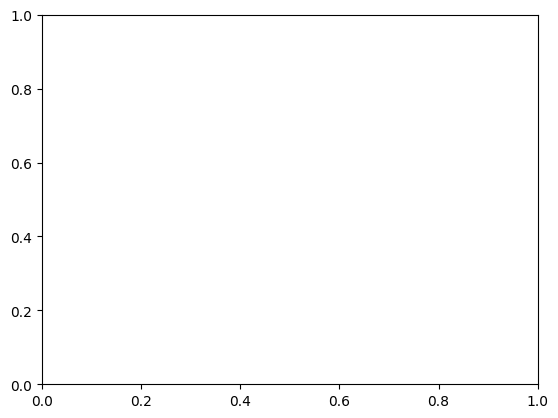

In [20]:
data_station, data_interpolation = interpolation[0], interpolation[1]

plt.scatter(np.array(data_station), np.array(data_interpolation))
plt.title('Comparando valor medido com interpolado')
plt.xlabel('Precipitação Estação (mm)')
plt.ylabel('Precipitação  Interpolada (mm)')

plt.show()

### Com 3 meses: 2010-05-15 até 2010-08-15

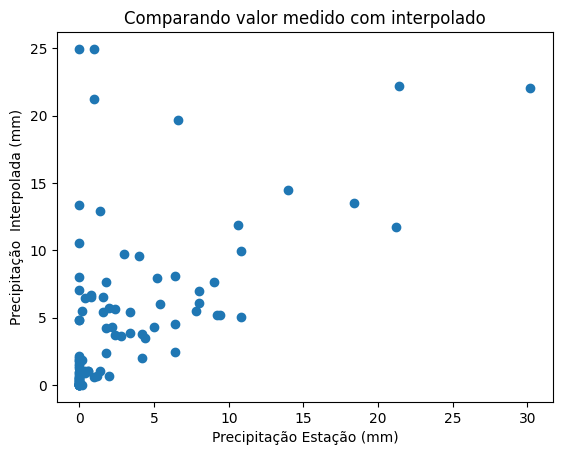

In [26]:
data_station, data_interpolation = interpolation[0], interpolation[1]

plt.scatter(np.array(data_station), np.array(data_interpolation))
plt.title('Comparando valor medido com interpolado')
plt.xlabel('Precipitação Estação (mm)')
plt.ylabel('Precipitação  Interpolada (mm)')

plt.show()

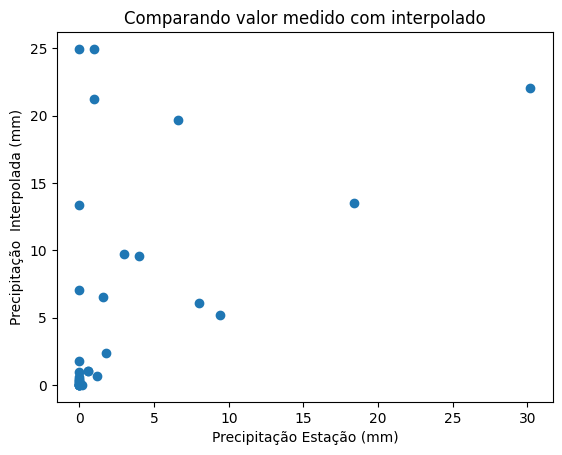

In [38]:
data_station, data_interpolation = interpolation[0], interpolation[1]

plt.scatter(np.array(data_station), np.array(data_interpolation))
plt.title('Comparando valor medido com interpolado')
plt.xlabel('Precipitação Estação (mm)')
plt.ylabel('Precipitação  Interpolada (mm)')

plt.show()

In [12]:
def bilinear(x, y, points):
    points = sorted(points)
    (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError('points do not form a retangle')
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError('(x, y) not within the retangle')
    
    return (q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)) / ((x2 - x1) * (y2 - y1) + 0.0)

In [ ]:
point_coords = sorted(lista_points)

bilinear()